In [10]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Verbessertes Plot-Layout
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Konfiguration für bessere Plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

In [12]:
class PokemonAnalyzer:
    def __init__(self, variant: str = 'v4'):
        self.variant = variant
        self.base_path = Path('../experiments') / variant
        self.run_dir = None
        self.df = None
        self.metadata = {}
        
    def get_available_runs(self) -> List[Path]:
        """Gibt alle verfügbaren Runs zurück, sortiert nach Datum"""
        if not self.base_path.exists():
            print(f" Experiment-Ordner nicht gefunden: {self.base_path}")
            return []
        
        runs = sorted([d for d in self.base_path.iterdir() if d.is_dir()])
        return runs
    
    def load_run(self, run_path: Path) -> pd.DataFrame:
        """Lädt alle JSON-Logs eines Runs und kombiniert sie"""
        self.run_dir = run_path
        json_folder = run_path / 'json_logs'
        
        if not json_folder.exists():
            print(f" JSON-Logs nicht gefunden: {json_folder}")
            return pd.DataFrame()
        
        # Alle JSON-Dateien laden
        json_files = sorted(json_folder.glob('*.json'))
        print(f" Gefundene JSON-Log-Dateien: {len(json_files)}")
        
        records = []
        for jf in json_files:
            try:
                data = json.loads(jf.read_bytes())
                # Falls data Liste ist, erweitern; falls Dict, als einzelnen Record hinzufügen
                if isinstance(data, list):
                    records.extend(data)
                else:
                    records.append(data)
            except Exception as e:
                print(f"⚠️ Fehler beim Laden von {jf.name}: {e}")
        
        # DataFrame erstellen
        df = pd.DataFrame.from_records(records)
        
        # Datentypen optimieren
        df = self._optimize_dtypes(df)
        
        # Metadata extrahieren
        self._extract_metadata(df)
        
        self.df = df
        print(f" Daten geladen: {len(df)} Einträge, {len(df.columns)} Spalten")
        return df
    
    def _optimize_dtypes(self, df: pd.DataFrame) -> pd.DataFrame:
        """Optimiert Datentypen für bessere Performance"""
        # Numerische Spalten optimieren
        for col in df.columns:
            if df[col].dtype == 'object':
                # Versuche numerische Konvertierung
                try:
                    df[col] = pd.to_numeric(df[col], errors='ignore')
                except:
                    pass
        
        # Spezifische Optimierungen
        if 'step' in df.columns:
            df['step'] = df['step'].astype('int64')
        
        for coord in ['x', 'y']:
            if coord in df.columns:
                df[coord] = pd.to_numeric(df[coord], errors='coerce')
        
        return df
    
    def _extract_metadata(self, df: pd.DataFrame):
        """Extrahiert Metadata für die Analyse"""
        self.metadata = {
            'total_entries': len(df),
            'columns': list(df.columns),
            'step_range': (df['step'].min(), df['step'].max()) if 'step' in df.columns else None,
            'has_position': 'x' in df.columns and 'y' in df.columns,
            'has_reward': 'reward' in df.columns or any('reward' in col for col in df.columns),
            'unique_episodes': df['episode'].nunique() if 'episode' in df.columns else None
        }
        
        print(f" Metadata:")
        for key, value in self.metadata.items():
            print(f"   {key}: {value}")

# Analyzer initialisieren
analyzer = PokemonAnalyzer()
runs = analyzer.get_available_runs()

# Interactive Run-Auswahl
if runs:
    run_dropdown = widgets.Dropdown(
        options=[(r.name, r) for r in runs],
        description='Run:',
        style={'description_width': 'initial'}
    )
    display(run_dropdown)
    
    # Automatisch letzten Run auswählen
    run_dropdown.value = runs[-1]
else:
    print(" Keine Runs gefunden!")

Dropdown(description='Run:', options=(('20250424_120248', WindowsPath('../experiments/v4/20250424_120248')), (…

In [13]:
# Daten laden
if 'run_dropdown' in locals():
    selected_run = run_dropdown.value
    df = analyzer.load_run(selected_run)
    
    # Erste Übersicht
    print("\n Daten-Übersicht:")
    print(df.info())
    print("\n Statistische Zusammenfassung:")
    print(df.describe())
    
    # Spalten analysieren
    print(f"\n Verfügbare Spalten: {list(df.columns)}")
    
    # Erste Rows anzeigen
    print("\n Erste 5 Einträge:")
    display(df.head())

 Gefundene JSON-Log-Dateien: 2
 Metadata:
   total_entries: 131072
   columns: ['step', 'position', 'rewards', 'player_status', 'actions', 'statistics']
   step_range: (0, 4095)
   has_position: False
   has_reward: True
   unique_episodes: None
 Daten geladen: 131072 Einträge, 6 Spalten

 Daten-Übersicht:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   step           131072 non-null  int64 
 1   position       131072 non-null  object
 2   rewards        131072 non-null  object
 3   player_status  131072 non-null  object
 4   actions        131072 non-null  object
 5   statistics     131072 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.0+ MB
None

 Statistische Zusammenfassung:
                step
count  131072.000000
mean     2047.500000
std      1182.417827
min         0.000000
25%      1023.750000
50%      2047.500

 Gefundene JSON-Log-Dateien: 2
 Metadata:
   total_entries: 131072
   columns: ['step', 'position', 'rewards', 'player_status', 'actions', 'statistics']
   step_range: (0, 4095)
   has_position: False
   has_reward: True
   unique_episodes: None
 Daten geladen: 131072 Einträge, 6 Spalten

 Daten-Übersicht:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   step           131072 non-null  int64 
 1   position       131072 non-null  object
 2   rewards        131072 non-null  object
 3   player_status  131072 non-null  object
 4   actions        131072 non-null  object
 5   statistics     131072 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.0+ MB
None

 Statistische Zusammenfassung:
                step
count  131072.000000
mean     2047.500000
std      1182.417827
min         0.000000
25%      1023.750000
50%      2047.500

,step,position,rewards,player_status,actions,statistics
0,0,"{'x': 3, 'y': 7, 'map': 38}","{'total': 0.0, 'step': 0.0, 'components': {'ev...","{'health': 0.0, 'levels': [0, 0, 0, 0, 0, 0], ...",{'last_action': 0},"{'deaths': 0, 'exploration_coords': 0, 'map_pr..."
1,1,"{'x': 3, 'y': 7, 'map': 38}","{'total': 0.0125, 'step': 0.0125, 'components'...","{'health': 0.0, 'levels': [0, 0, 0, 0, 0, 0], ...",{'last_action': 5},"{'deaths': 0, 'exploration_coords': 1, 'map_pr..."
2,2,"{'x': 3, 'y': 6, 'map': 38}","{'total': 0.0125, 'step': 0.0125, 'components'...","{'health': 0.0, 'levels': [0, 0, 0, 0, 0, 0], ...",{'last_action': 3},"{'deaths': 0, 'exploration_coords': 1, 'map_pr..."
3,3,"{'x': 3, 'y': 7, 'map': 38}","{'total': 0.025, 'step': 0.025, 'components': ...","{'health': 0.0, 'levels': [0, 0, 0, 0, 0, 0], ...",{'last_action': 0},"{'deaths': 0, 'exploration_coords': 2, 'map_pr..."
4,4,"{'x': 3, 'y': 7, 'map': 38}","{'total': 0.025, 'step': 0.025, 'components': ...","{'health': 0.0, 'levels': [0, 0, 0, 0, 0, 0], ...",{'last_action': 5},"{'deaths': 0, 'exploration_coords': 2, 'map_pr..."


TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

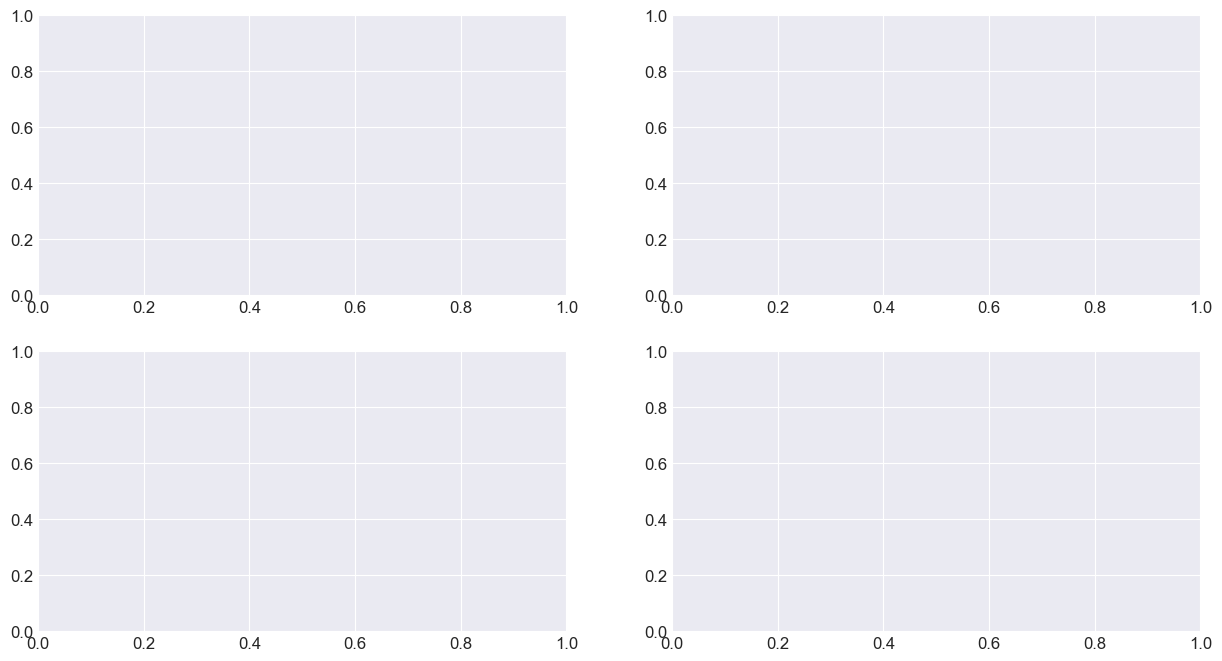

In [14]:
def plot_episode_rewards(df: pd.DataFrame, figsize: Tuple[int, int] = (15, 8)):
    """Plottet Episode-Rewards über die Zeit"""
    
    # Reward-Spalten identifizieren
    reward_cols = [col for col in df.columns if 'reward' in col.lower()]
    
    if not reward_cols:
        print("Keine Reward-Spalten gefunden!")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    # 1. Gesamt-Reward über Steps
    if 'step' in df.columns and 'reward' in df.columns:
        ax = axes[0]
        
        # Episode-basierte Aggregation
        if 'episode' in df.columns:
            episode_rewards = df.groupby('episode')['reward'].sum().reset_index()
            episode_steps = df.groupby('episode')['step'].max().reset_index()
            
            ax.plot(episode_steps['step'], episode_rewards['reward'], 
                   alpha=0.7, linewidth=1, label='Episode Reward')
            
            # Gleitender Durchschnitt
            window = min(50, len(episode_rewards) // 10)
            if window > 1:
                rolling_mean = episode_rewards['reward'].rolling(window=window).mean()
                ax.plot(episode_steps['step'], rolling_mean, 
                       color='red', linewidth=2, label=f'Moving Average ({window})')
        
        ax.set_xlabel('Training Steps')
        ax.set_ylabel('Episode Reward')
        ax.set_title('Episode Rewards über Training')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 2. Reward-Verteilung
    if 'reward' in df.columns:
        ax = axes[1]
        df['reward'].hist(bins=50, alpha=0.7, ax=ax)
        ax.set_xlabel('Reward')
        ax.set_ylabel('Frequency')
        ax.set_title('Reward-Verteilung')
        ax.grid(True, alpha=0.3)
    
    # 3. Reward-Komponenten (falls vorhanden)
    reward_components = [col for col in reward_cols if col != 'reward']
    if reward_components:
        ax = axes[2]
        
        # Durchschnittliche Komponenten-Werte
        component_means = df[reward_components].mean()
        component_means.plot(kind='bar', ax=ax)
        ax.set_title('Durchschnittliche Reward-Komponenten')
        ax.set_xlabel('Komponente')
        ax.set_ylabel('Durchschnittlicher Wert')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    # 4. Kumulativer Reward
    if 'reward' in df.columns:
        ax = axes[3]
        cumulative_reward = df['reward'].cumsum()
        ax.plot(df.index, cumulative_reward, linewidth=2)
        ax.set_xlabel('Step Index')
        ax.set_ylabel('Kumulativer Reward')
        ax.set_title('Kumulativer Reward über Zeit')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot erstellen
if 'df' in locals() and len(df) > 0:
    plot_episode_rewards(df)

In [16]:
def plot_position_heatmap(df: pd.DataFrame, figsize: Tuple[int, int] = (12, 10)):
    """Erstellt eine verbesserte Position-Heatmap"""
    
    # Position-Daten filtern
    df_pos = df.dropna(subset=['x', 'y'])
    
    if len(df_pos) == 0:
        print("Keine Positions-Daten gefunden!")
        return
    
    print(f"Position-Einträge: {len(df_pos)}")
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Klassische Heatmap
    ax = axes[0, 0]
    counts = df_pos.groupby(['y', 'x']).size().unstack(fill_value=0)
    
    im = ax.imshow(counts.values, origin='lower', aspect='equal', 
                   interpolation='nearest', cmap='YlOrRd')
    plt.colorbar(im, ax=ax, label='# Visits')
    ax.set_title('Position-Heatmap (Visits)')
    ax.set_xlabel('X-Koordinate')
    ax.set_ylabel('Y-Koordinate')
    
    # 2. Logarithmische Heatmap (für bessere Visualisierung)
    ax = axes[0, 1]
    log_counts = np.log1p(counts.values)  # log(1+x) für bessere Skalierung
    im = ax.imshow(log_counts, origin='lower', aspect='equal', 
                   interpolation='nearest', cmap='viridis')
    plt.colorbar(im, ax=ax, label='log(1 + Visits)')
    ax.set_title('Position-Heatmap (Log-Skaliert)')
    ax.set_xlabel('X-Koordinate')
    ax.set_ylabel('Y-Koordinate')
    
    # 3. Trajectory-Plot (zeitliche Entwicklung)
    ax = axes[1, 0]
    
    # Sample für bessere Performance bei großen Datenmengen
    sample_size = min(5000, len(df_pos))
    df_sample = df_pos.sample(n=sample_size).sort_values('step')
    
    # Farbkodierung nach Zeit
    scatter = ax.scatter(df_sample['x'], df_sample['y'], 
                        c=df_sample['step'], cmap='plasma', 
                        alpha=0.6, s=1)
    plt.colorbar(scatter, ax=ax, label='Training Step')
    ax.set_title(f'Agent-Trajectory (Sample: {sample_size} Punkte)')
    ax.set_xlabel('X-Koordinate')
    ax.set_ylabel('Y-Koordinate')
    
    # 4. Density-Plot mit Seaborn
    ax = axes[1, 1]
    
    # Weitere Samples für Density-Plot
    sample_size_density = min(10000, len(df_pos))
    df_density = df_pos.sample(n=sample_size_density)
    
    try:
        sns.kdeplot(data=df_density, x='x', y='y', cmap='Reds', 
                   fill=True, ax=ax)
        ax.set_title(f'Position-Density (Sample: {sample_size_density} Punkte)')
        ax.set_xlabel('X-Koordinate')
        ax.set_ylabel('Y-Koordinate')
    except Exception as e:
        ax.text(0.5, 0.5, f'Density-Plot Fehler:\n{e}', 
               transform=ax.transAxes, ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Zusätzliche Statistiken
    print(f"\n Positions-Statistiken:")
    print(f"   X-Range: {df_pos['x'].min():.1f} - {df_pos['x'].max():.1f}")
    print(f"   Y-Range: {df_pos['y'].min():.1f} - {df_pos['y'].max():.1f}")
    print(f"   Unique Positionen: {len(df_pos.groupby(['x', 'y']))}")
    print(f"   Durchschnittliche Position: ({df_pos['x'].mean():.1f}, {df_pos['y'].mean():.1f})")

# Plot erstellen
if 'df' in locals() and len(df) > 0:
    plot_position_heatmap(df)

KeyError: ['x', 'y']